# Equation of state
In this notebook, we examine the equation of state for the simulated gas relating gas' pressure, temperature and number density. We do not expect it to obey the ideal gas alw in general as the discs possess finite size. Instead we expect to to obey a Van der Waal's relation, namely,
$$
P
=
\frac{n k_B T}{1 - 2n \pi R^2},
$$
where $R$ is the radii of the discs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import billiards as bl

In [2]:
def compute_sim_pressure(sim, bottom_left, top_right):
    """Computes the pressure using the simulation provided"""

    cur_v = sim.initial_state['v']
    masses = sim.initial_state['m']
    total_dP = 0.0  # total change in momentum
    
    for e in sim.events:
        if e.disc_wall_col==bl.PyCol_Type.Disc_Wall:
            
            dv = e.new_v - cur_v[e.ind]
            
            total_dP += masses[e.ind] * np.linalg.norm(dv)
        
        cur_v[e.ind] = e.new_v

    # Pressure if total change in momentum / time over which momentum change occured / "area" of box's surface
    dt = sim.events[-1].t - sim.events[0].t
    A = 2*np.sum(top_right - bottom_left)  # As we're in 2d, the "area" is really perimeter of box
    
    return total_dP / (dt * A)

In [3]:
def measure_pressure(n, kB_T, R):
    """
    Determines the pressure for a gas with number density n and temperature T by running a simulation
    """
    
    # Number, speed, masses, radii of discs
    N_discs = 2500
    v = 1.0
    m = 1.0
    
    # Setup the simulation
    L = np.sqrt(N_discs / n)  # Simulation width
    bottom_left = np.array([-L/2, -L/2])
    top_right = np.array([L/2, L/2])

    sim = bl.PySim(bottom_left, top_right, 49, 49)

    sim.add_random_discs(bottom_left, top_right, N_discs, m, R, kB_T=kB_T, pos_allocation='grid')

    sim.setup()
    sim.advance(100000, 10000.0, True)
    
    return compute_sim_pressure(sim, bottom_left, top_right)

## Pressure vs temperature
Now determine the relationship between pressure and temperature.

In [4]:
def test_P_T_relationship(kB_T, n):
    """Runs a simulation to determine the pressure for the given T values & n"""
    R = 1.0
    
    sim_pressure = [measure_pressure(n, T, R) for T in kB_T]
        
    expected_pressure_func = lambda T: n / (1 - n * 2*np.pi*R**2) * T
    
    return sim_pressure, expected_pressure_func

In [5]:
test_temp = np.linspace(0.01, 1.0, 11)  # Really kB_T

sim_pressure, expected_pressure_func = test_P_T_relationship(test_temp, n=0.01)

pred_temp = np.linspace(test_temp[0], test_temp[-1], 1000)
pred_pressure = expected_pressure_func(pred_temp)

pred_pressure_at_samples = expected_pressure_func(test_temp)

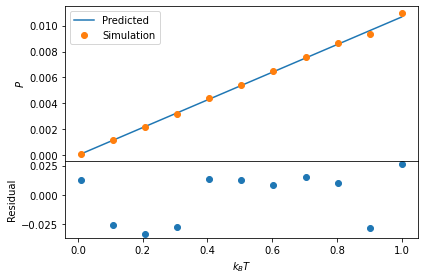

In [6]:
# Create plot
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0}, sharex=True)

ax1.plot(pred_temp, pred_pressure, label="Predicted")
ax1.plot(test_temp, sim_pressure, 'o', label="Simulation")

ax2.plot(test_temp, (sim_pressure - pred_pressure_at_samples) / pred_pressure_at_samples, 'o')

ax2.set_xlabel("$k_B T$")
ax1.set_ylabel("$P$")
ax2.set_ylabel("Residual")

ax1.legend()

plt.tight_layout()
plt.show()

## Pressure vs number density
Now determine the relationship between pressure and number density.

In [7]:
def test_P_n_relationship(kB_T, n):
    """Runs several simulations to determine the pressure for several n values given T"""
    
    R = 1.0

    sim_pressure = [measure_pressure(n_v, kB_T, R) for n_v in n]
    
    expected_pressure_func = lambda n_v: n_v / (1 - n_v * 2*np.pi*R**2) * kB_T
    
    return sim_pressure, expected_pressure_func

In [8]:
test_n = np.linspace(0.001, 0.05, 11)  # Really kB_T

sim_pressure, expected_pressure_func = test_P_n_relationship(kB_T=1.0, n=test_n)

pred_n = np.linspace(test_n[0], test_n[-1], 1000)
pred_pressure = expected_pressure_func(pred_n)

pred_pressure_at_samples = expected_pressure_func(test_n)

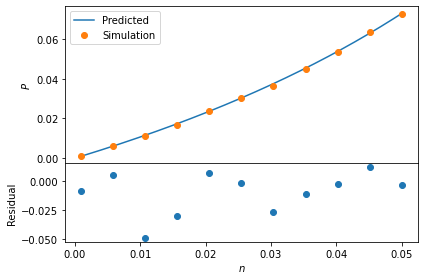

In [9]:
# Create plot
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0}, sharex=True)

ax1.plot(pred_n, pred_pressure, label="Predicted")
ax1.plot(test_n, sim_pressure, 'o', label="Simulation")

ax2.plot(test_n, (sim_pressure - pred_pressure_at_samples) / pred_pressure_at_samples, 'o')

ax2.set_xlabel("$n$")
ax1.set_ylabel("$P$")
ax2.set_ylabel("Residual")

ax1.legend()

plt.tight_layout()
plt.show()